<a href="https://colab.research.google.com/github/ssaran2014/tensorflow/blob/master/imdb_reviews_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This colab notebook does sentiment analysis on the imdb_reviews dataset found here: https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import numpy as np
import matplotlib.pyplot as plt

In [23]:
#helper function to extract sentences and to convert labels to arrays
def sentence_label_prep(ds):
  sentences = []
  labels = []

  for element in list(ds.as_numpy_iterator()):
    sentences.append(tf.compat.as_str_any(element[0]))
    labels.append(element[1])

  #convert labels from list to np.array
  labels = np.array(labels)
  
  #print(len(train_sentences))
  #print(len(train_labels))
  return sentences, labels



#load data; convert labels to arrays
def load_data():
  (train_ds, val_ds, test_ds), info = tfds.load('imdb_reviews', 
                                              shuffle_files=True, 
                                              split = ('train[:60%]', 'train[60%:]', 'test'),
                                              as_supervised=True, 
                                              with_info=True)

  #print info
  print(info)

  #train_sentences, train_labels = sentence_label_prep(ds['train'])
  #test_sentences, test_labels = sentence_label_prep(ds['test'])
  train_sentences, train_labels = sentence_label_prep(train_ds)
  val_sentences, val_labels = sentence_label_prep(val_ds)
  test_sentences, test_labels = sentence_label_prep(test_ds)

  return train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels

#train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels = load_data()

In [24]:
#tokenize words; form into sequences; check that sentences can be tokenized and reversed
def preprocess(train_sentences, val_sentences, test_sentences, print_test = False):
  num_words = 10000
  oov_token = "<OOK>"

  #create tokenizer
  tokenizer = Tokenizer(num_words = num_words, oov_token=oov_token)
  
  #fit on text. This is required before creating sequences
  tokenizer.fit_on_texts(train_sentences)
  word_index = tokenizer.word_index
  reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

  #create sequence
  list_of_train_sequences = tokenizer.texts_to_sequences(train_sentences)
  list_of_val_sequences = tokenizer.texts_to_sequences(val_sentences)
  list_of_test_sequences = tokenizer.texts_to_sequences(test_sentences)

  #pad the sequences
  max_len = 500
  truncating = 'post'
  train_padded_sequences = pad_sequences(list_of_train_sequences, maxlen = max_len, truncating=truncating)
  val_padded_sequences = pad_sequences(list_of_val_sequences, maxlen=max_len)
  test_padded_sequences = pad_sequences(list_of_test_sequences, maxlen=max_len)

  #check if the process of converting to index is working by checking to reverse the process
  if print_test:
    print(train_sentences[0])
    print('\n')
    print(' '.join([reverse_word_index.get(i, '?') for i in train_padded_sequences[0].tolist()]))

  return train_padded_sequences, val_padded_sequences, test_padded_sequences

#train_padded_sequences, val_padded_sequences, test_padded_sequences = preprocess(train_sentences, val_sentences, test_sentences)

In [25]:
#create embeddings and model
def define_model(train_padded_sequences, train_labels, val_padded_sequences, val_labels, test_padded_sequences, test_labels):
  vocab_size = 10000
  embedding_dim =128
  input_length = 500

  model = tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = input_length),
                               #tf.keras.layers.Conv1D(128, 5, activation='relu'),
                               tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(32, return_sequences = True)),
                               tf.keras.layers.GlobalAveragePooling1D(),
                               #tf.keras.layers.Flatten(),
                               tf.keras.layers.Dense(250, activation = 'relu'),
                               tf.keras.layers.Dropout(0.5),
                               tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])

  model.summary()

  model.compile(
      optimizer = 'adam',
      loss = 'binary_crossentropy',
      metrics = ['accuracy']
  )

  history = model.fit(
      train_padded_sequences, train_labels,
      epochs = 5,
      validation_data = (val_padded_sequences, val_labels),
      verbose = 1
  )

  _, accuracy = model.evaluate(test_padded_sequences, test_labels)
  print('Accuracy on test data: {:0.2f}'.format(accuracy))

  return history

#history = define_model(train_padded_sequences, train_labels, val_padded_sequences, val_labels, test_padded_sequences, test_labels)

In [26]:
#plotting charts
%matplotlib inline

def make_plots(history):
  fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

  ax1.plot(history.history['loss'], label = 'training')
  ax1.plot(history.history['val_loss'], label = 'val')
  ax1.set_title('Loss Curve')
  ax1.set_ylim(0,1)


  ax2.plot(history.history['accuracy'], label = 'training')
  ax2.plot(history.history['val_accuracy'], label = 'val')
  ax2.set_title('Accuracy Curve')
  ax2.set_ylim(0,1.1)
  plt.show()

#make_plots(history)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

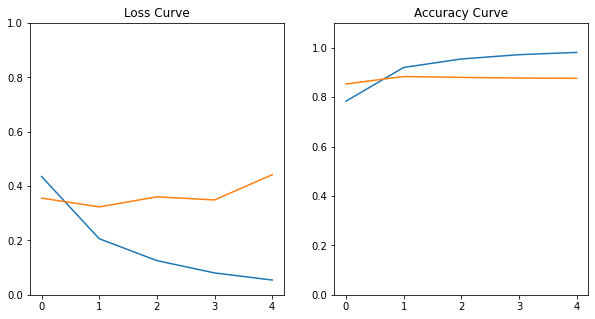

In [28]:
#full sequential function
def run_imdb_sentiment_analysis():
  #load data
  train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels = load_data()

  #tokenize and pad sequences
  train_padded_sequences, val_padded_sequences, test_padded_sequences = preprocess(train_sentences, val_sentences, test_sentences)

  #create model
  history = define_model(train_padded_sequences, train_labels, val_padded_sequences, val_labels, test_padded_sequences, test_labels)

  #plot loss and accuracy curves
  make_plots(history)

run_imdb_sentiment_analysis()